# Проект "Телекоммуникации"

__Описание проекта__: Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.

__Цель проекта__: Прогнозирование оттока клиентов.

**Описание данных:**

Данные состоят из нескольких файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Файл `contract_new.csv`

- **customerID** — идентификатор абонента;
- **BeginDate** — дата начала действия договора;
- **EndDate** — дата окончания действия договора;
- **Type** — тип оплаты: раз в год-два или ежемесячно;
- **PaperlessBilling** — электронный расчётный лист;
- **PaymentMethod** — тип платежа;
- **MonthlyCharges** — расходы за месяц;
- **TotalCharges** — общие расходы абонента.

Файл `personal_new.csv`

- **customerID** — идентификатор пользователя;
- **gender** — пол;
- **SeniorCitizen** — является ли абонент пенсионером;
- **Partner** — есть ли у абонента супруг или супруга;
- **Dependents** — есть ли у абонента дети.

Файл `internet_new.csv`

- **customerID** — идентификатор пользователя;
- **InternetService** — тип подключения;
- **OnlineSecurity** — блокировка опасных сайтов;
- **OnlineBackup** — облачное хранилище файлов для резервного копирования данных;
- **DeviceProtection** — антивирус;
- **TechSupport** — выделенная линия технической поддержки;
- **StreamingTV** — стриминговое телевидение;
- **StreamingMovies** — каталог фильмов.

Файл `phone_new.csv`

- **customerID** — идентификатор пользователя;
- **MultipleLines** — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец **customerID** содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

**План работы:**

**Шаг 1. Загрузка данных**

**Шаг 2. Предобработка данных**

**Шаг 3. Объединение данных**

**Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма**

**Шаг 5. Подготовка данных для обучения модели**

**Шаг 6. Обучение моделей машинного обучения**

**Шаг 7. Выбор лучшей модели**

**Шаг 8. Общий вывод и рекомендации заказчику**

## Шаг 1. Загрузка данных

### Импорт библиотек

In [1]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import shap
import warnings

from phik.report import plot_correlation_matrix
from phik import report

from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    f1_score,
    roc_auc_score,
    auc,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay
)


from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

warnings.simplefilter(action='ignore', category=FutureWarning)
RANDOM_STATE = 240225

### Загрузим данные

**Создадим функцию для открытия и чтения файлов внезависимости от их локации.**

In [2]:
def open_csv(name):
    pth1 = name
    pth2 = f'/datasets/{name}'
    
    if os.path.exists(pth1):
        opened_file = pd.read_csv(pth1)
        return opened_file
    elif os.path.exists(pth2):
        opened_file = pd.read_csv(pth2)
        return opened_file
    else:
        print('Something is wrong')

**Создадим функцию для приведения названия столбцов в змеиный регистр**

In [3]:
def to_snake_case(column_name):
    s = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', column_name)
    s = re.sub('([a-z0-9])([A-Z])', r'\1_\2', s) 
    return s.lower()

In [4]:
contract_new = open_csv('contract_new.csv')
contract_new.columns = [to_snake_case(col) for col in contract_new.columns]
contract_new.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [5]:
personal_new = open_csv('personal_new.csv')
personal_new.columns = [to_snake_case(col) for col in personal_new.columns]
personal_new.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [6]:
internet_new = open_csv('internet_new.csv')
internet_new.columns = [to_snake_case(col) for col in internet_new.columns]
internet_new.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [7]:
phone_new = open_csv('phone_new.csv')
phone_new.columns = [to_snake_case(col) for col in phone_new.columns]
phone_new.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**Вывод: были импортированы библиотеки и загружены данные.**

## Шаг 2. Исследовательский анализ и предобработка данных

Выполним исследовательский анализ каждого датафрейма и при необходимости выполним предобработку. Сделаем выводы об имеющихся признаках: понадобятся ли они для обучения моделей.

### Предобработка данных

**Проверим наличие пропусков в данных.**

**contract_new**

In [8]:
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Пропусков нет. У столбца 'total_charges' некорректный тип, поменяем его на числовой тип.

In [9]:
contract_new['total_charges'] = pd.to_numeric(contract_new['total_charges'], errors='coerce')
contract_new['total_charges'].dtype

dtype('float64')

У столбца 'begin_date' некорректный тип, поменяем его на тип date.

In [10]:
contract_new['begin_date'] = pd.to_datetime(contract_new['begin_date'],format= "%Y-%m-%d")
contract_new['begin_date'].dtype

dtype('<M8[ns]')

У столбца 'end_date' некорректный тип, так как кроме даты, он содержит значения 'No', создадим на следующем шаге дополнительные признаки с длительностью контракта и целевой признак, ушел ли пользователь.

**personal_new**

In [11]:
personal_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Пропусков нет. У столбца 'senior_citizen' некорректный тип, поменяем его на тип 'object'.

In [12]:
personal_new['senior_citizen'] = personal_new['senior_citizen'].astype('object')
personal_new['senior_citizen'].dtype #проверка

dtype('O')

**internet_new**

In [13]:
internet_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Пропусков нет.

**phone_new**

In [14]:
phone_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Пропусков нет.

**Проверим наличие дубликатов в данных**

In [15]:
contract_new.duplicated().sum()

0

Проверим на неявные дубликаты

In [16]:
contract_new.duplicated(subset=['begin_date',	'end_date',	'type',	'paperless_billing',	'payment_method',	'monthly_charges',	'total_charges'], 
                 keep=False).sum()

73

In [17]:
duplicates = contract_new[
    contract_new.duplicated(
        subset=[
            'begin_date', 
            'end_date', 
            'type', 
            'paperless_billing', 
            'payment_method', 
            'monthly_charges', 
            'total_charges'
        ], 
        keep=False
    )
]

duplicates.sort_values(by=['begin_date', 'end_date','total_charges'])

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
2279,5334-AFQJB,2014-02-01,No,Two year,Yes,Credit card (automatic),25.10,1807.20
3466,9430-NKQLY,2014-02-01,No,Two year,Yes,Credit card (automatic),25.10,1807.20
714,4312-KFRXN,2014-02-01,No,Two year,No,Mailed check,25.40,1828.80
5024,8774-GSBUN,2014-02-01,No,Two year,No,Mailed check,25.40,1828.80
1363,3084-DOWLE,2014-02-01,No,Two year,No,Bank transfer (automatic),92.00,6624.00
...,...,...,...,...,...,...,...,...
6338,2081-KJSQF,2020-01-01,No,Month-to-month,Yes,Mailed check,20.25,22.07
4641,9895-VFOXH,2020-01-01,No,Month-to-month,No,Mailed check,24.40,24.40
6536,3439-GVUSX,2020-01-01,No,Month-to-month,No,Mailed check,24.40,24.40
2037,8309-IEYJD,2020-01-01,No,Month-to-month,Yes,Mailed check,70.60,70.60


В данных могут быть люди, заключившие контракты в один день по одним и тем же условиям, у которых контракт с одинаковой длительностью и набором услуг, такие строки будут совпадать, но не обязательно будут дубликатами, оставим их.

In [18]:
personal_new.duplicated().sum()

0

In [19]:
internet_new.duplicated().sum()

0

In [20]:
phone_new.duplicated().sum()

0

Явных дубликатов нет.

**Проверим, есть ли ошибки и неявные дубликаты в категориальных столбцах.**

In [21]:
contract_new['payment_method'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [22]:
contract_new['type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [23]:
personal_new['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [24]:
internet_new['internet_service'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

Ошибок в категориальных столбцах нет.

Итак, в столбце 'end_date' кроме даты содержатся значения 'No', создадим на следующем шаге дополнительные признаки с длительностью контракта и целевой признак, ушел ли пользователь. Возможно, какие-то признаки нам не понадобятся, например, 'gender', 'end_date', 'paperless_billing', часть признаков из группы интернет-услуг (могут быть сильно взаимозависимы) - оценим на этапе корреляционного анализы.

**Выводы: на данном этапе данные были проверены на пропуски и дубликаты, сделаны предположения о том, какие признаки понадобятся для обучения моделей.**

## Объединение данных

In [25]:
merged_df = (
    contract_new
    .merge(personal_new, on='customer_id', how='left')
    .merge(internet_new, on='customer_id', how='left')
    .merge(phone_new, on='customer_id', how='left')
)

In [26]:
merged_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [27]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

В 'total_charges' 11 пропусков, менее 0.2% от датасета, можно удалить. Так как пропуски в остальных столбцах скорее всего связаны с тем, что у пользователей нет пакета услуг интернета, заменим их на 'Not used'.

In [28]:
columns_with_na = ['internet_service', 'online_security', 
                   'online_backup', 'device_protection', 'tech_support', 
                   'streaming_tv', 'streaming_movies', 'multiple_lines']
merged_df[columns_with_na] = merged_df[columns_with_na].fillna('not used')

In [29]:
merged_df = merged_df.dropna().reset_index(drop=True)

In [30]:
# Проверяем результат
print(merged_df.isnull().sum())

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64


Установим 'customer_id' в качестве индекса.

In [31]:
merged_df.set_index('customer_id', inplace=True)
merged_df.shape

(7032, 19)

Добавим целевой признак 'User_status', где 1 - ушел, 0 остался

In [32]:
merged_df['user_status'] = np.where(merged_df['end_date'] == 'No', 0, 1)

Добавим признак 'contract_duration'.

In [33]:
merged_df['end_date'] = np.where(merged_df['end_date'] =='No', '2020-02-01', merged_df['end_date'])

In [34]:
merged_df['end_date'] = pd.to_datetime(merged_df['end_date'])
merged_df['contract_duration'] = (merged_df['end_date'] - merged_df['begin_date']).dt.days

In [35]:
merged_df.shape

(7032, 21)

In [36]:
merged_df.sample(5) #проверка

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,user_status,contract_duration
customer_id,,,,,,,,,,,,,,,,,,,,,
6340-DACFT,2015-12-01,2020-01-01,Two year,No,Credit card (automatic),20.55,1006.95,Female,0,Yes,...,not used,not used,not used,not used,not used,not used,not used,No,1,1492
5172-RKOCB,2014-02-01,2018-11-01,Two year,Yes,Credit card (automatic),108.95,6582.76,Male,0,Yes,...,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,Yes,1,1734
1150-WFARN,2014-05-01,2019-05-01,Two year,Yes,Credit card (automatic),108.75,7112.25,Female,0,Yes,...,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Yes,1,1826
6711-FLDFB,2019-04-01,2020-02-01,Month-to-month,Yes,Electronic check,74.90,749.00,Female,0,No,...,Fiber optic,No,No,No,No,No,No,Yes,0,306
8111-SLLHI,2016-10-01,2019-06-01,Month-to-month,Yes,Electronic check,105.65,3685.07,Male,1,Yes,...,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,1,973


**Вывод: данные были объединены, на выходе мы получили датафрейм из 7032 строк и 21 столбца.**

## Исследовательский анализ и предобработка данных объединённого датафрейма

Проведем исследовательский анализ признаков.

**Проанализируем количественные признаки**

In [37]:
def hist_box(df,column):
    fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (18,8))
    sn.histplot(data = df,x = column, ax=axs[0], bins = 40, kde=True)
    axs[0].set_xlabel(column)
    axs[0].set_ylabel('Количество')
    axs[0].set_title('Гистограмма')
    axs[0].grid(True) 
    sn.boxplot(data = df,x = column, ax=axs[1])
    axs[1].set_xlabel(column)
    axs[1].set_title('Диаграмма размаха')
    fig.suptitle(f'Гистограмма и диаграмма размаха для {column}')
    plt.show()
    print(df[column].describe())

**Гистограмма и диаграмма размаха для ежемесячных расходов пользователя.**

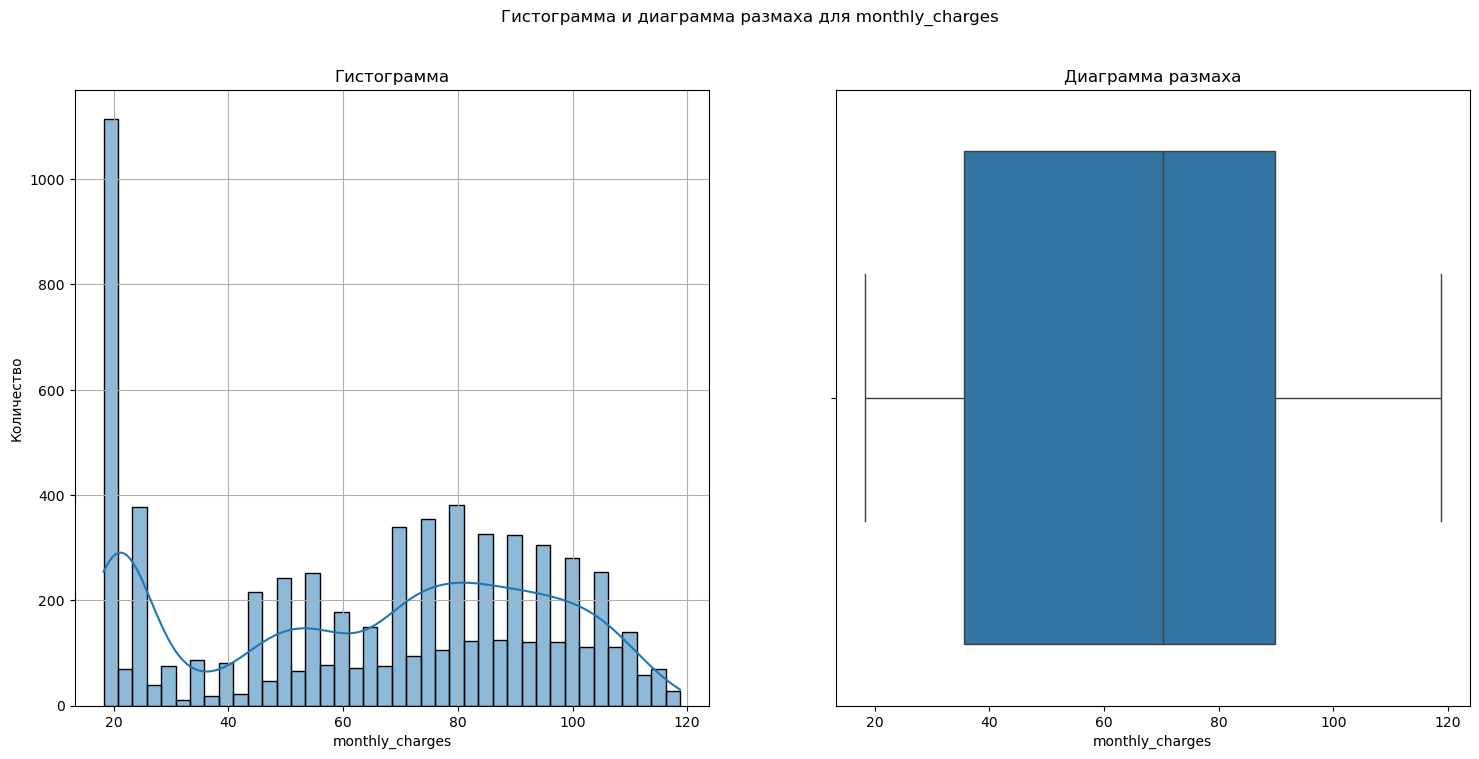

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: monthly_charges, dtype: float64


In [38]:
hist_box(merged_df,'monthly_charges')

In [39]:
def plot_countplot(df, category, target):
    plt.figure(figsize=(10, 6))
    sn.countplot(data=df, x=category, hue=target)
    plt.title(f'Количество по категориям {category} в зависимости от {target}')
    plt.xlabel(category)
    plt.ylabel('Количество')
    plt.legend(title=target)
    plt.grid(True)
    plt.show()

In [40]:
def plot_pairplot(df, target):
    sn.pairplot(df, hue=target)
    plt.title(f'Парные графики с учетом {target}')
    plt.show()

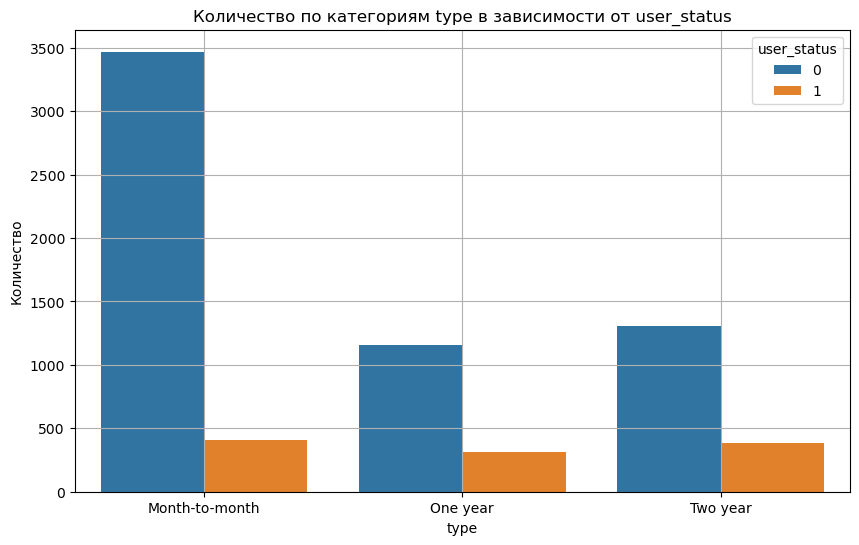

In [42]:
# Визуализация countplot
plot_countplot(merged_df, 'type', 'user_status')

Выбросов нет. На гистограмме ежемесячные расходов наблюдается пик в более чем 1000 наблюдений около ежемесячных расходов равных 20, также есть небольшие пики около 24 и 80 (чуть менее 400 наблюдений каждый), скорее всего, есть многочисленная группа пользователей, у которых самый низкий тарифный план, либо промо-предложение.

Среднее значение (mean): 64.76, что указывает на то, что средний ежемесячный расход пользователей составляет около 64.76 единиц.

Стандартное отклонение (std): 30.09, что говорит о значительном разбросе данных вокруг среднего значения.

Минимум (min): 18.25, что подтверждает наличие очень низких расходов.

Медиана (50%): 70.35, что близко к среднему значению, указывая на относительно симметричное распределение.

Максимум (max): 118.75, что показывает, что есть пользователи с более высокими расходами.

**Гистограмма и диаграмма размаха для общих расходов пользователя.**

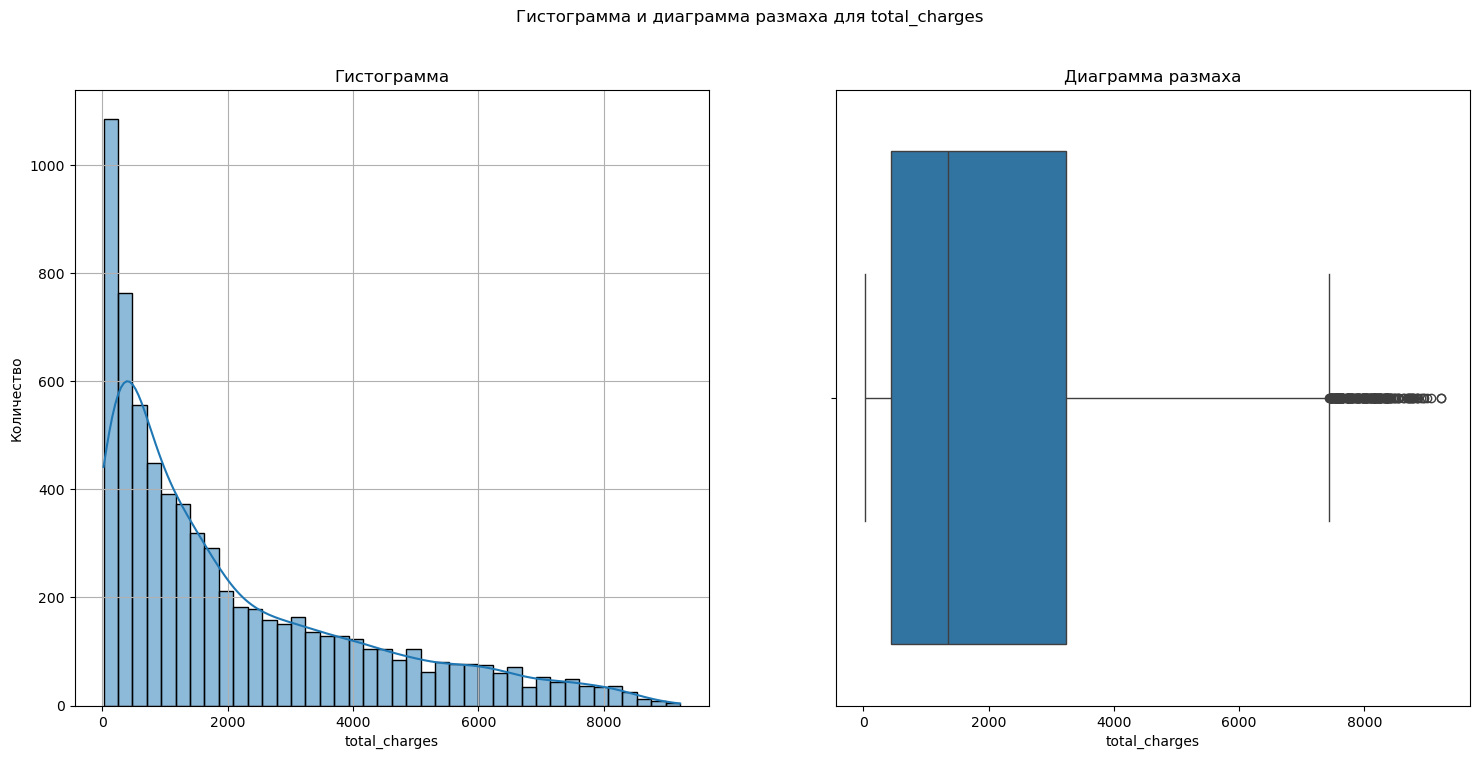

count    7032.000000
mean     2118.621822
std      2112.736199
min        19.050000
25%       439.745000
50%      1345.275000
75%      3239.317500
max      9221.380000
Name: total_charges, dtype: float64


In [43]:
hist_box(merged_df,'total_charges')

Выбросы присутствуют, но не выглядят аномальными, оставим их.

На гистограмме общих расходов видно, что большинство значений сосредоточены от 0 до 2000, пик в диапазоне от 0 до 200, что также позвозляет преположить, что многие пользователи используют самый низкий тарифный план, либо пользовались\пользуются промо-предложениями. 

С увеличением суммы расходов количество наблюдений уменьшается, что говоритет о том, что очень небольшая часть пользователей тратит большие суммы.

Среднее значение (mean): 2118.62 - средний уровень общих расходов пользователей.

Стандартное отклонение (std): 2112.74, что говорит о значительном разбросе данных, что характерно для распределения с длинным хвостом.

Минимум (min): 19.05, что показывает наличие пользователей с очень низкими расходами.

Медиана (50%): 1345.28 ниже среднего значения, то есть распределение асимметрично с перекосом в сторону меньших значений.

Максимум (max): 9221.38, что показывает наличие пользователей с очень высокими общими расходами.

**Гистограмма и диаграмма размаха длительности контракта пользователя.**

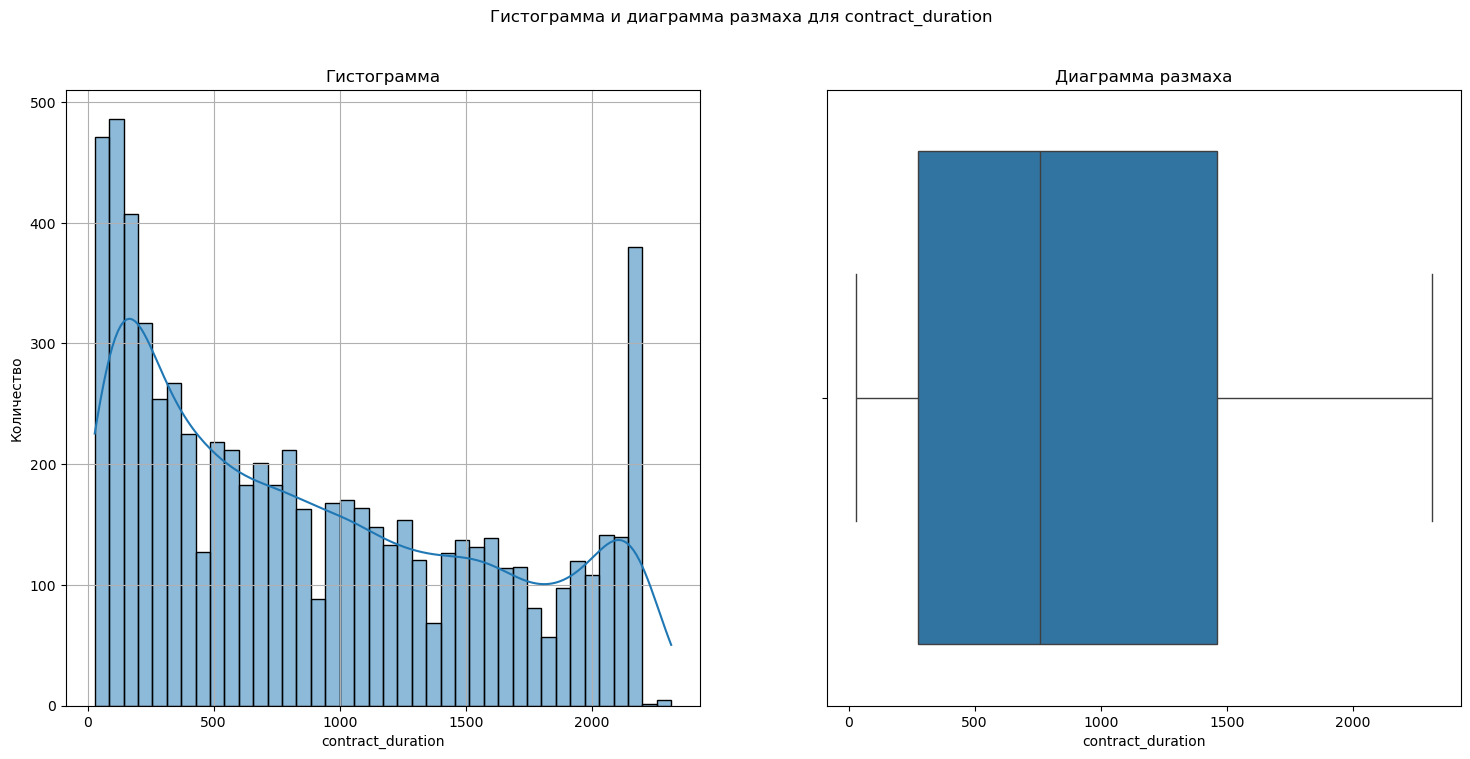

count    7032.000000
mean      899.961320
std       682.738777
min        28.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: contract_duration, dtype: float64


In [44]:
hist_box(merged_df,'contract_duration')

Выбросов нет.

Среднее (mean): 899.96 — средняя длительность контракта близка к 900 дням

Стандартное отклонение (std): 682.74 — это значение довольно высокое по сравнению со средним, что говорит о значительном разбросе в длительности контрактов.

Минимум (min): 28 — минимальная длительность контракта составляет 28 дней, что может указывать на наличие краткосрочных контрактов.

Медиана (50%): 761 — половина контрактов имеет длительность менее 761 дня, что также указывает на наличие коротких и средних контрактов.

Максимум (max): 2314 — максимальная длительность контракта составляет более 6 лет.

Таким образом, в выборке присутствуют как краткосрочные, так и долгосрочные контракты, но распределение имеет два пика(около 30 и около 2300), поэтому несмотря на то, что большая часть контрактов имеет относительно короткую длительность (что отражает медиана), второй пик в районе долгосрочных контрактов несколько увеличивает среднее значение.

**Проанализируем качественные признаки**

Вероятно, признак PaperlessBilling — электронный расчётный лист не влияют на продление подписки, но пока оставим его.

Создадим функцию для столбчатой диаграммы.

In [45]:
def bar_plot(df, column):
    plt.figure(figsize=(9, 6))
    ax = sn.countplot(x=column, data=df)

    total = len(df) 
    for p in ax.patches:
        height = p.get_height()  # Высота столбца
        percentage = (height / total) * 100  # Вычисление процента
        ax.annotate(f'{percentage:.1f}%', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom')

    plt.title(f'Столбчатая диаграмма для {column}')
    plt.xlabel(f'Значения {column}')
    plt.ylabel('Количество наблюдений')
    plt.grid(True)
    plt.show()

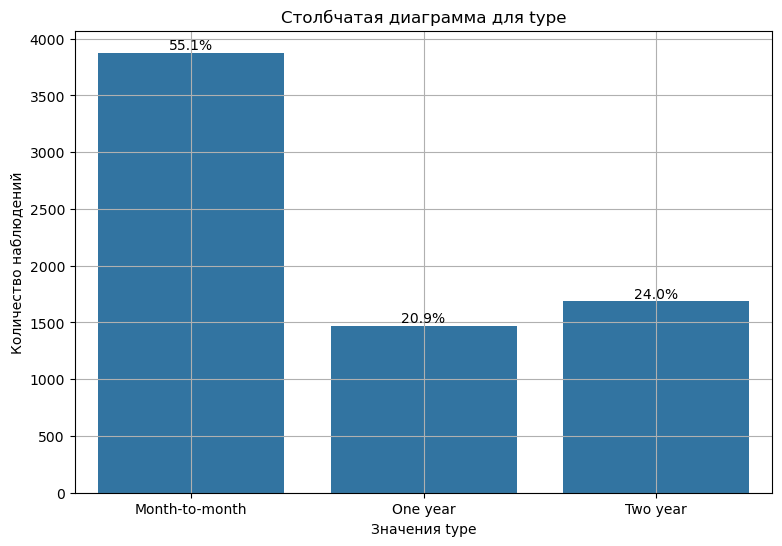

In [46]:
bar_plot(merged_df, 'type')

Более половины пользователей используют тип оплаты "ежемесячно", четверть пользователей использует оплату раз в два года, пятая часть пользователей оплачивает раз в год.

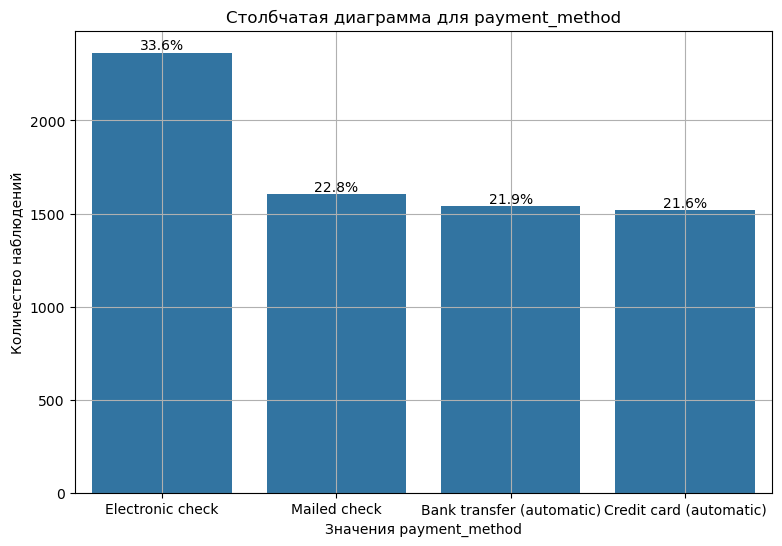

In [47]:
bar_plot(merged_df,'payment_method')

Треть пользователей (около 33%) предпочитают метод оплаты 'Electronic check'. Остальные методы оплаты ('mailed check', 'automatic', 'credit card') распределены примерно поровну между оставшимися пользователями, так что каждый из этих методов использует примерно пятая часть пользователей. 


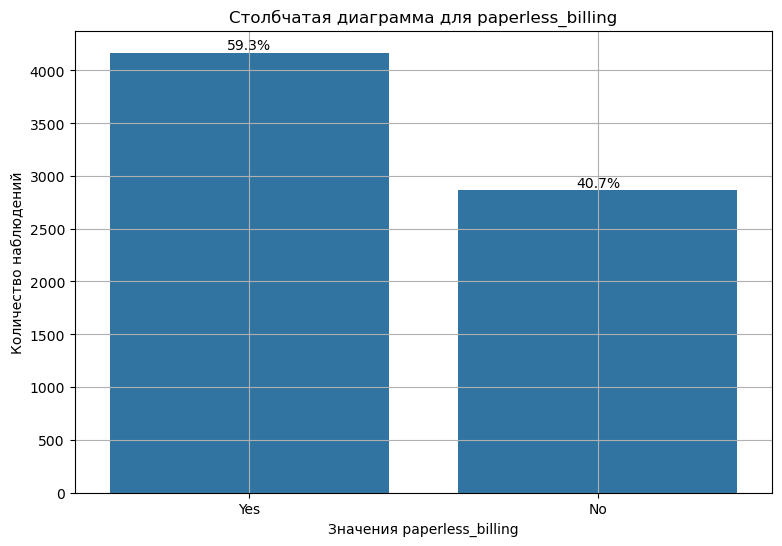

In [48]:
bar_plot(merged_df, 'paperless_billing')

Большая часть пользователей использует электронный рассчетный лист.

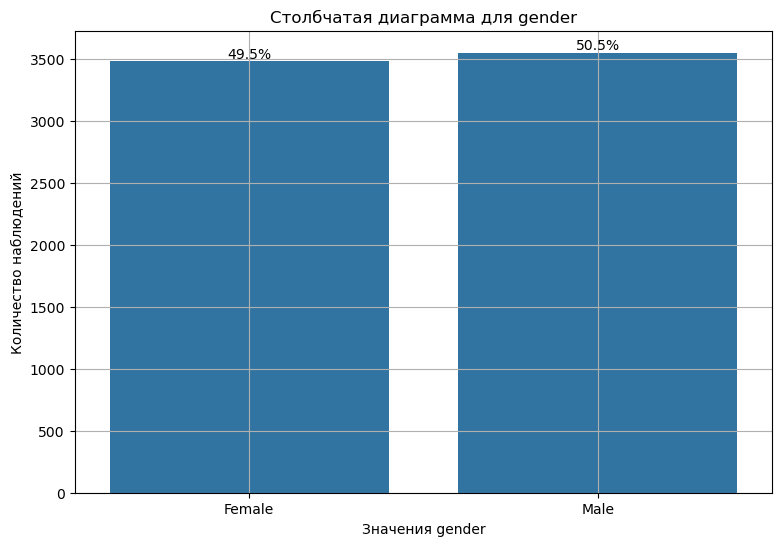

In [49]:
bar_plot(merged_df,'gender')

Соотношение полов среди клиентов примерно равное.

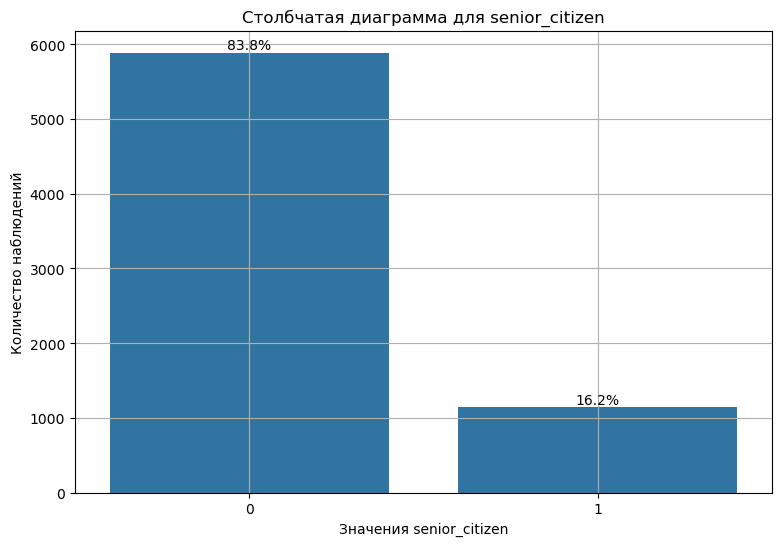

In [50]:
bar_plot(merged_df,'senior_citizen')

Среди пользователей 16.2% пенсионеров.

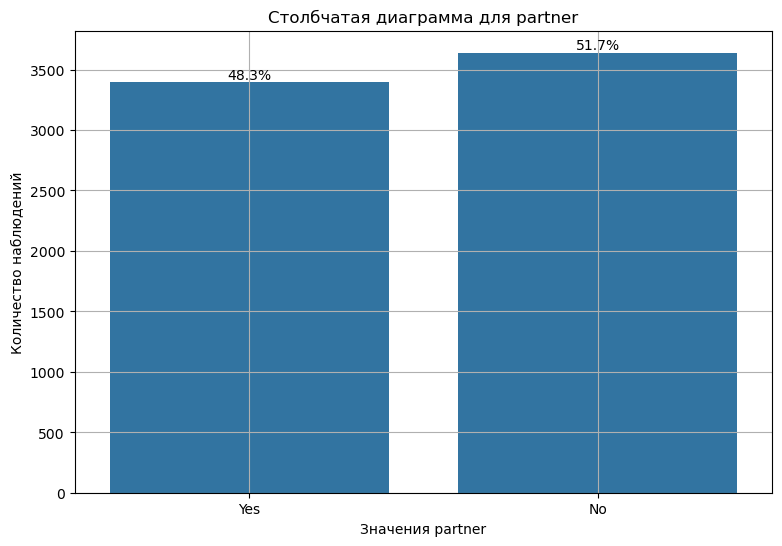

In [51]:
bar_plot(merged_df,'partner')

Соотношение пользователей, находящихся в браке и неженатых\незамужних, примерно равное.

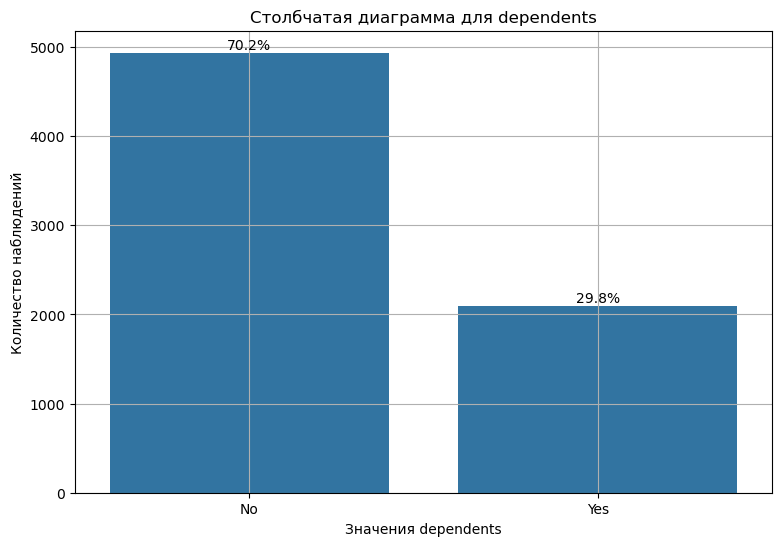

In [52]:
bar_plot(merged_df,'dependents')

Чуть менее трети пользователей имеют детей.

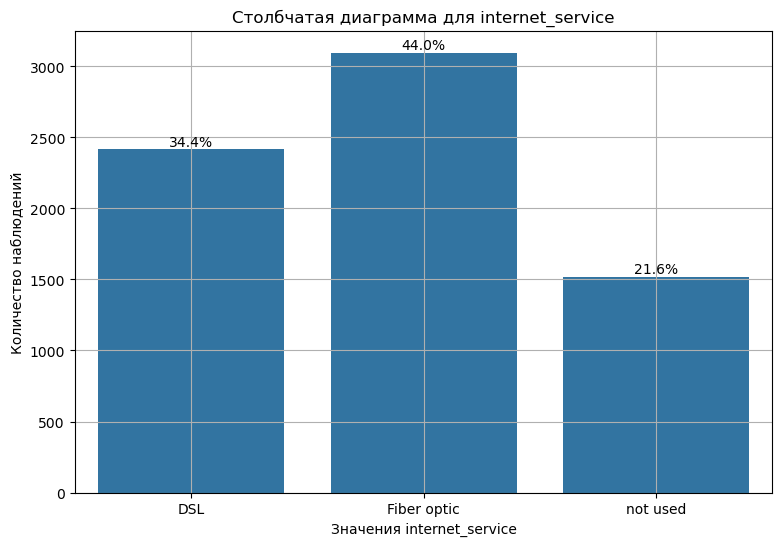

In [53]:
bar_plot(merged_df,'internet_service')

Подключение через телефонную линию (DSL) используют 34.4% пользователей, 44% подключаются через оптоволоконный кабель (Fiber optic). Не пользуются услугами интернера 21.6% пользоваталей. 

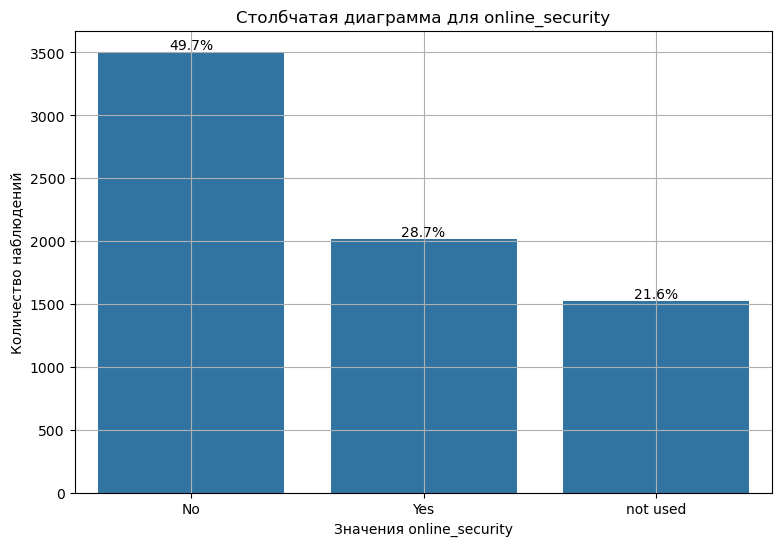

In [54]:
bar_plot(merged_df,'online_security')

Блокировку небезопасных сайтов используют 28.7% пользователей, половина пользователей интернета не пользуется услугой блокировки, также не пользуются услугами интернета 21.6% пользоваталей. 

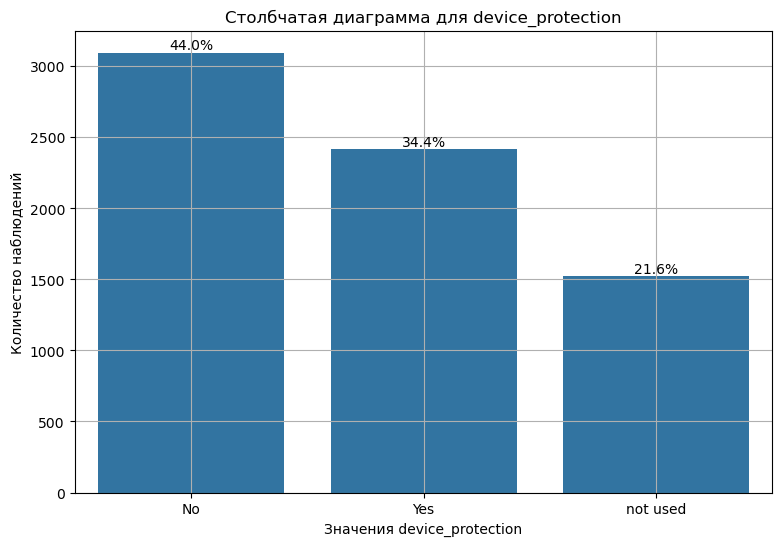

In [55]:
bar_plot(merged_df,'device_protection')

Антивирус используют 34.4% пользователей, 44% пользователей интернета не пользуется этой услугой, также не пользуются услугами интернета 21.6% пользоваталей. 

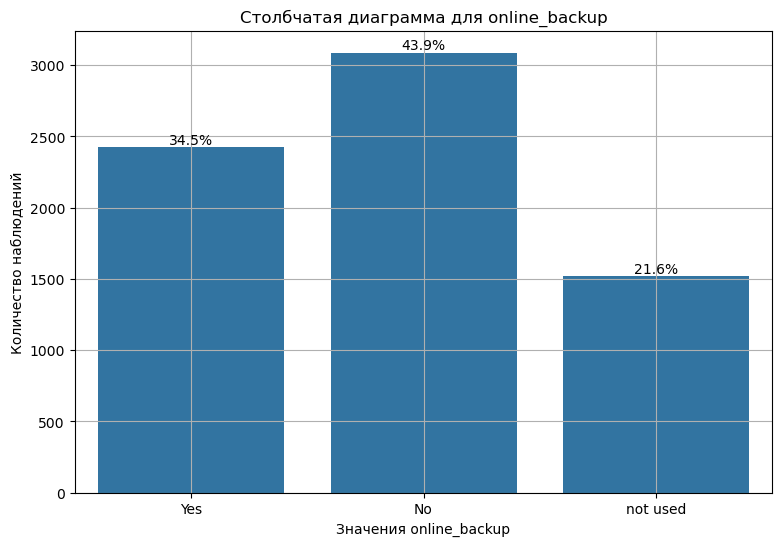

In [56]:
bar_plot(merged_df,'online_backup')

Облачное хранилище используют 34.5% пользователей, 43.9% пользователей интернета не пользуется этой услугой, также не пользуются услугами интернета 21.6% пользоваталей. 

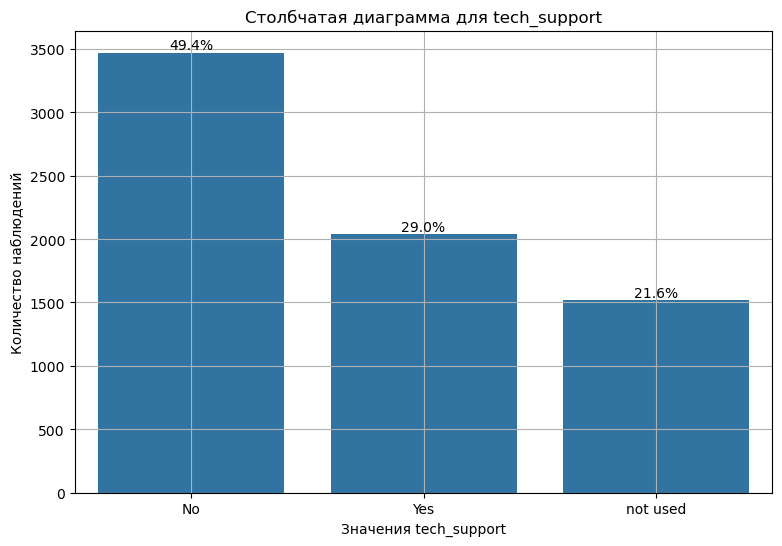

In [57]:
bar_plot(merged_df,'tech_support')

Выделенную линию техподдержки используют 29% пользователей, 49.4% пользователей интернета не пользуется этой услугой, также не пользуются услугами интернета 21.6% пользоваталей. 

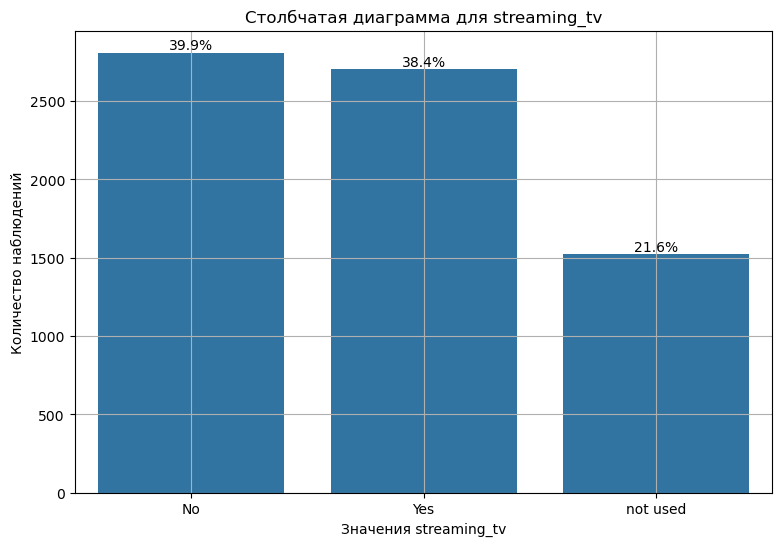

In [58]:
bar_plot(merged_df,'streaming_tv')

Услугой стримингового ТВ используют 38.4% пользователей, 39.9% пользователей интернета не пользуется этой услугой, также не пользуются услугами интернета 21.6% пользоваталей. 

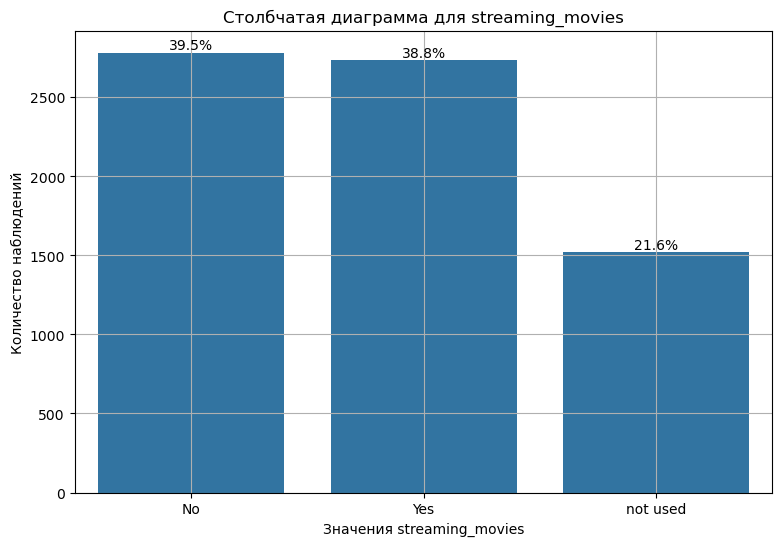

In [59]:
bar_plot(merged_df,'streaming_movies')

Каталог фильмов используют 38.8% пользователей, 39.5% пользователей интернета не пользуется этой услугой, также не пользуются услугами интернета 21.6% пользоваталей. 

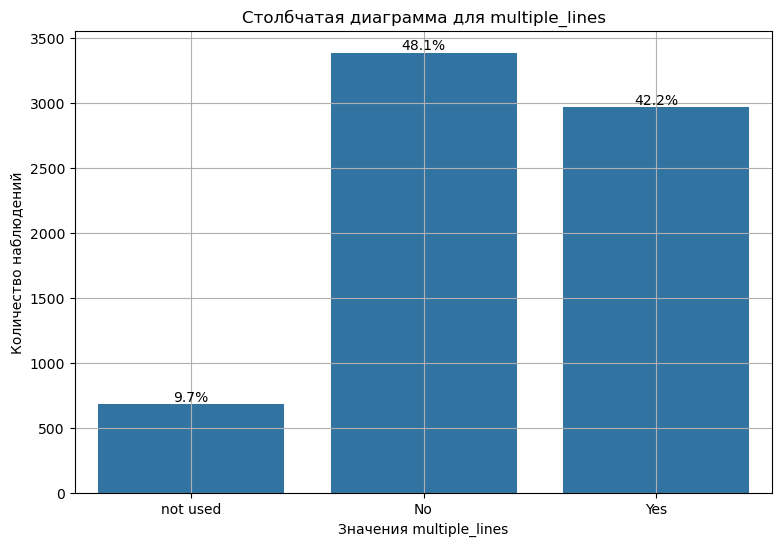

In [60]:
bar_plot(merged_df, 'multiple_lines')

Подключение к нескольким линиями используют 42.2% пользователей, остальные пользователи не пользуются этой услугой. 

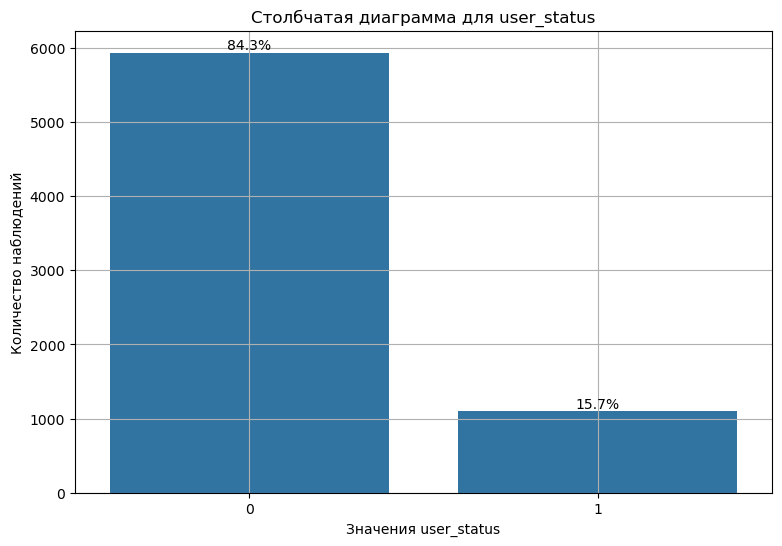

In [61]:
bar_plot(merged_df, 'user_status')

По целевому признаку есть дисбаланс классов, необходимо будет учесть это на следующих шагах и выбрать модели, которые хорошо работают с дисбалансом классов, например дерево решений, бустинговые модели. В качестве основной метрики выберем roc_auc, дополним оценку метрикой accuracy.

**Проведем корреляционный анализ признаков. Сделаем выводы о мультиколлинеарности и при необходимости устраним её.**

In [62]:
merged_df = merged_df.drop(['begin_date', 'end_date'], axis=1) #удалим даты

In [63]:
phik_corr = merged_df.phik_matrix(
    interval_cols = ['monthly_charges',	'total_charges', 'contract_duration']
) 
#phik_corr

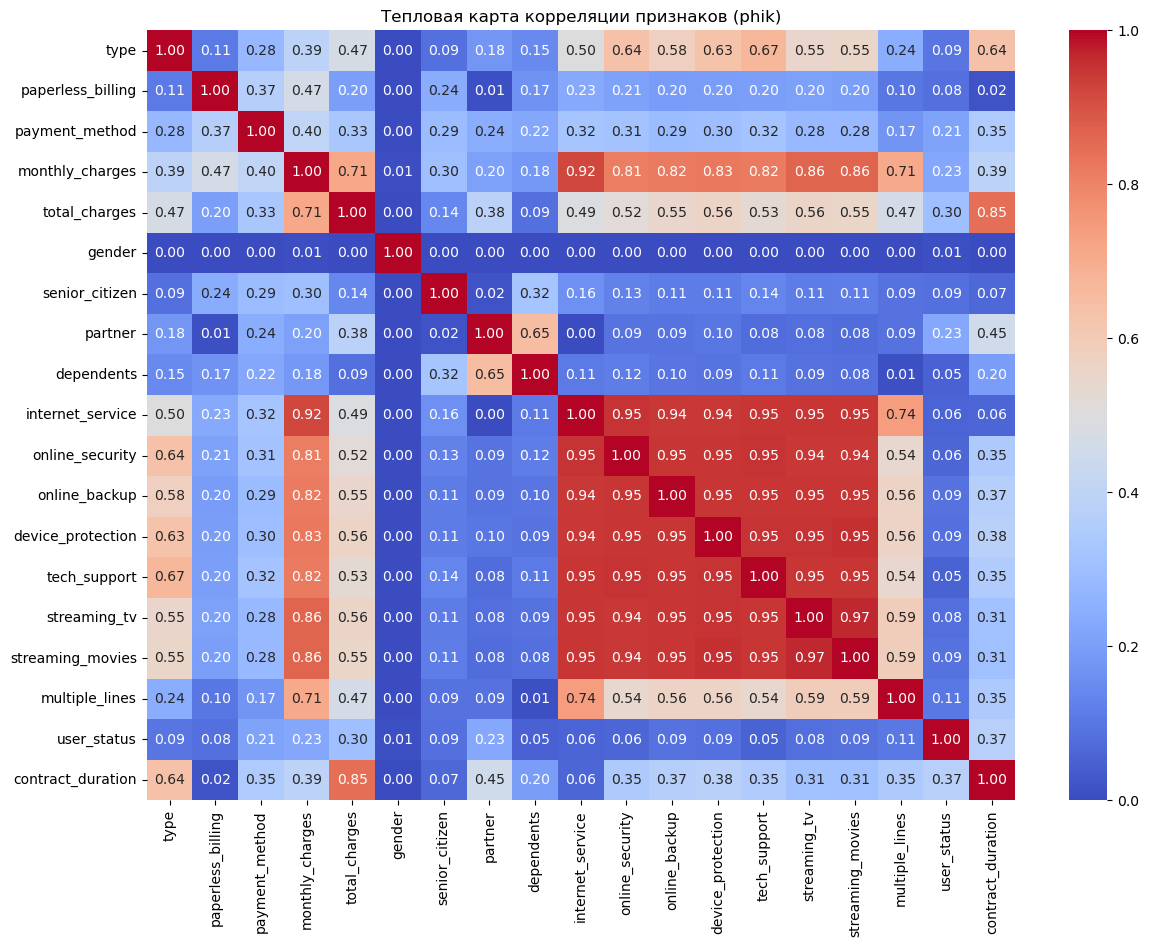

In [64]:
plt.figure(figsize=(14, 10))
sn.heatmap(phik_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Тепловая карта корреляции признаков (phik)')
plt.show()

По корреляции можно выделить следующие группы:

**Группа 1:** Услуги, связанные с интернетом (internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies) имеют между собой очень высокую корреляцию от 0.94 до 0.97 , то есть клиенты, которые пользуются одной интернет-услугой, скорее всего, пользуются и другими.

**Группа 2:** Ежемесячные расходы 'monthly_charges' сильно коррелируют с услугами интернета (internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies) с корреляцией от 0.81 до 0.92.

**Группа 3:** Тип оплаты 'type' умеренно коррелирует с интернет услугами от 0.5 до 0.67.

**Группа 4:** Общие расходы умеренно коррелирует с интернет услугами от 0.5 до 0.56.

**Группа 5:** Наличие несколько линий телефонной связи с услугами интернета и стриминга ТВ. 


Есть умеренная корреляция между типом оплаты и длительностью контракта(0.64).
Ожидаемо сильная корреляция между общими расходами и длительностью контракта 0.85 и между общими и ежемесячными расходами 0.71.6

Пол 'gender' не коррелирует ни с целевым, ни с остальными признаками. Удалим его на следующем шаге. Признаки 'streaming_movies' и 'streaming_tv' являются мультиколлинеарными с коэффициентом 0.97, поэтому один из них необходимо удалить.

**Рассмотрим как разные группы по типу длительности контракта распределены по парам переменных**

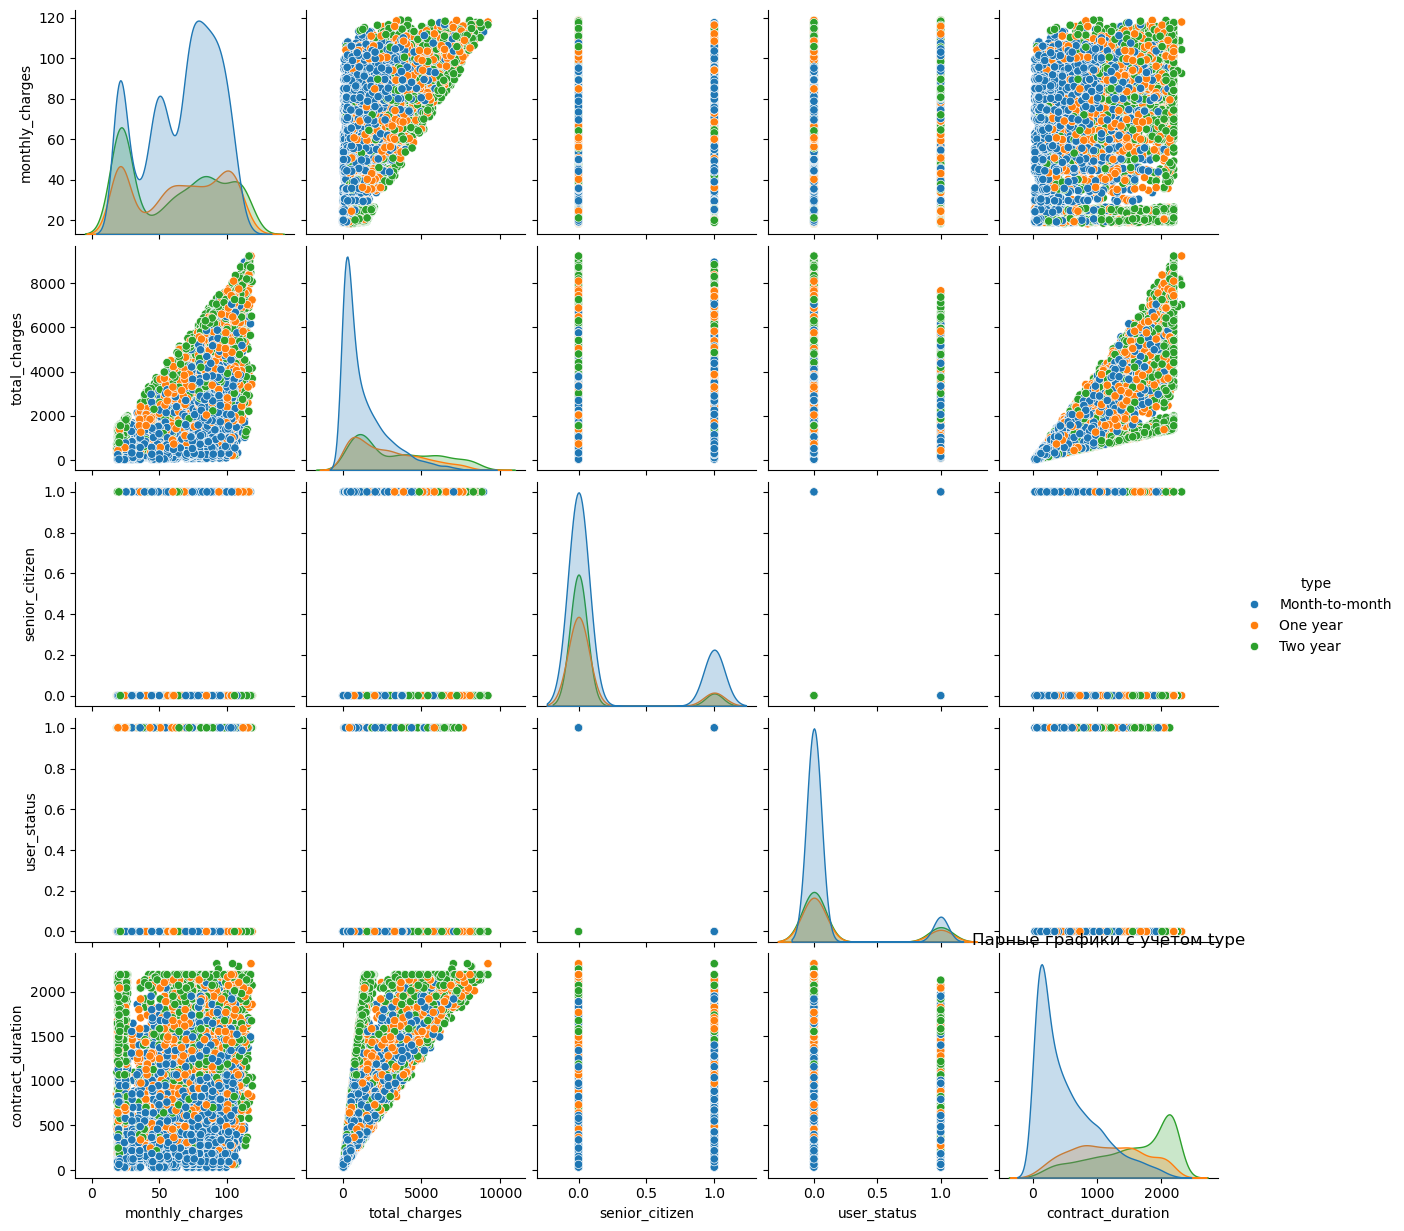

In [65]:
plot_pairplot(merged_df, 'type')

Матрица парных признаков показывает, что тип контракта по длительности действительно сегментирует пользователей и сильно влияет на траты, длительность контракта, статус и т.д. Ежемесячные расходы имеют три пика для ежемесячного типа контракта, а для более длительных контрактов пик находится в диапазоне от 10 до 40. Общие расходы имеют вид треугольника, основание которого с небольшими расходами заполнено в основном наблюдениями с типом оплаты контракта "ежемесячно". Группа пользователей с типом оплаты "ежемесячно" имеет низкие общие расходы, низкую длительность контракта, преобладает среди пользователей.


**Вывод:** 

**Анализ расходов и длительности контракта позволяет предположить, что есть многочисленная группа пользователей, у которых низкий тарифный план, либо промо-предложение. Группа пользователей с высокими тратами немногочисленна.**

- **Большинство пользователей используют ежемесячный платеж.**
- **Треть пользователей (около 33%) предпочитают метод оплаты 'Electronic check'. Остальные методы оплаты ('mailed check', 'automatic', 'credit card') распределены примерно поровну между оставшимися пользователями.**
- **Распределение пользователей по семейному статусу примерно равное, у 70% абонентов нет детей, 16% пользователей пенсионеры.**
- **21.6% пользователей не пользуются интернет услугами.**

**Интернет услуги являются драйвером ежемесячных трат пользователей, поэтому стоит стимулировать клиентов подключать больше интернет-услуг, предлагая пакетные предложения, выгодные тарифы или бонусы. Есть значительная корреляция между общими расходами и длительностью контракта и расходами. Возможно, компании стоит мотивировать пользователей заключать более длительные контракты.**

## Подготовка данных

Выполним подготовку данных для обучения модели. Разделим данные на две выборки, при масштабировании и кодировании учтем особенности данных и моделей.

Подготовку признаков выполним в пайплайне.

In [66]:
y = merged_df['user_status']
X = merged_df.drop(['user_status', 'streaming_tv', 'gender'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
        X,
        y, 
        test_size=0.25, 
        random_state=RANDOM_STATE
)

In [67]:
X_train.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_movies,multiple_lines,contract_duration
customer_id,,,,,,,,,,,,,,,,
5726-CVNYA,Two year,Yes,Mailed check,19.85,158.80,0,Yes,Yes,not used,not used,not used,not used,not used,not used,No,245
6253-GNHWH,Two year,No,Mailed check,71.10,5502.43,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,No,Yes,2163
1029-QFBEN,Month-to-month,No,Mailed check,19.55,102.64,0,No,No,not used,not used,not used,not used,not used,not used,No,153
5171-EPLKN,Two year,No,Credit card (automatic),19.85,535.95,0,No,No,not used,not used,not used,not used,not used,not used,No,822
4700-UBQMV,One year,Yes,Bank transfer (automatic),75.90,1593.90,0,Yes,Yes,DSL,Yes,No,No,No,Yes,Yes,641


In [68]:
ohe_columns = [
    'payment_method', 
    'senior_citizen', 
    'partner', 
    'dependents', 
    'internet_service', 
    'online_security', 
    'online_backup', 
    'device_protection', 
    'tech_support', 
    'streaming_movies', 
    'multiple_lines',
    'paperless_billing'
]

ord_columns = ['type']

num_columns = [
    'monthly_charges', 
    'total_charges', 
    'contract_duration'
]

cat_list = [
    'payment_method', 
    'senior_citizen', 
    'partner', 
    'dependents', 
    'internet_service', 
    'online_security', 
    'online_backup', 
    'device_protection', 
    'tech_support', 
    'streaming_movies', 
    'multiple_lines',
    'type',
    'paperless_billing'
]


In [69]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
        
    ]
)
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),

(
            'ord',  
            OrdinalEncoder(
                categories='auto', 
                handle_unknown='use_encoded_value',
                unknown_value=6
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

data_preprocessor = ColumnTransformer(
    [ 
        ('num', MinMaxScaler(), num_columns),
        ('cat', ord_pipe, cat_list)
    ], 
    remainder='passthrough'
) 

In [70]:
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

С учетом, что у нас задача классификации с дисбалансом классов выберем следующие модели.

In [71]:
param_grid = [
    
        # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1, 10),
        'preprocessor__cat': [ohe_pipe]  
    },
    # словарь для модели DecisionTreeClassifier()
        {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(5,12),
        'models__max_features': range(7,15)
    },
    # словарь для модели CatBoostClassifier()
        {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)],
        'models__max_depth': range(5,12),
        'models__iterations': [500, 1000],
        'models__learning_rate': [0.05, 0.1, 0.15, 0.2]
    },
        {
        'models': [lgb.LGBMClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200, 300, 500],
        'models__max_depth': [ 10, 12, 15, 20],
        'models__learning_rate':[ 0.1, 0.2, 0.5, 0.75 ]
    }

]

**Вывод: Была выполнена подготовка данных для обучения модели, данные были разделены на обучающую и тестовую выборку, был создан пайплайн с четырьмя моделями LogisticRegression, DecisionTreeClassifier, CatBoostClassifier, LGBMClassifier и набором гиперпараметров.**

## Обучение моделей машинного обучения

In [72]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               MinMaxScaler(),
                                                                               ['monthly_charges',
                                                                                'total_charges',
                                                                                'contract_duration']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',...
                                        {'models': [<catboost.core.CatBoostClassifier object at 0x0000017A88AB9790>],
                                         'models__iterations': [500, 1000],
                                         'models__learning_rate': [0.05, 0.1,
                                                                   0.15, 0.2],
                                         'models__max_depth': range(5, 12)},
                                        {'models': [LGBMClassifier(random_state=240225)],
                                         'models__learning_rate': [0.1, 0.2,
                                                                   0.5, 0.75],
                                         'models__max_depth': [10, 12, 15, 20],
                                         'models__n_estimators': [100, 200, 300,
                                                                  500]}],
                   random_state=240225, scoring='roc_auc')

In [73]:
print('Лучшая модель:\n\n', randomized_search.best_estimator_)
print ('Лучшие параметры:', randomized_search.best_params_)
print ('Метрика лучшей модели при кросс-валидации:', randomized_search.best_score_)

Лучшая модель:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['monthly_charges',
                                                   'total_charges',
                                                   'contract_duration']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=6)),
                                                   

In [74]:
for i, params in enumerate(randomized_search.cv_results_['params']):
    print(f"Модель {i+1}: {randomized_search.cv_results_['mean_test_score'][i]:.2f}, Параметры: {params}")

print('Модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика модели при кросс-валидации:', randomized_search.best_score_)

Модель 1: 0.88, Параметры: {'models__max_depth': 8, 'models__learning_rate': 0.05, 'models__iterations': 500, 'models': <catboost.core.CatBoostClassifier object at 0x0000017A88AB9790>}
Модель 2: 0.73, Параметры: {'models__max_features': 7, 'models__max_depth': 11, 'models': DecisionTreeClassifier(random_state=240225)}
Модель 3: 0.88, Параметры: {'models__max_depth': 9, 'models__learning_rate': 0.2, 'models__iterations': 500, 'models': <catboost.core.CatBoostClassifier object at 0x0000017A88AB9790>}
Модель 4: 0.76, Параметры: {'models__max_features': 7, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=240225)}
Модель 5: 0.88, Параметры: {'models__n_estimators': 300, 'models__max_depth': 15, 'models__learning_rate': 0.1, 'models': LGBMClassifier(random_state=240225)}
Модель 6: 0.91, Параметры: {'models__max_depth': 5, 'models__learning_rate': 0.1, 'models__iterations': 500, 'models': <catboost.core.CatBoostClassifier object at 0x0000017A88AB9790>}
Модель 7: 0.77, Пар

In [75]:
results = pd.DataFrame({'Модель': ['LogisticRegression', 'DecisionTreeClassifier', 'LightGBM', 'CatBoostRegressor'],
                        'ROC_AUC на тестовой выборке': [0.77, 0.76, 0.88, 0.91]})

results

,Модель,ROC_AUC на тестовой выборке
0,LogisticRegression,0.77
1,DecisionTreeClassifier,0.76
2,LightGBM,0.88
3,CatBoostRegressor,0.91


Лучшей моделью стала CatBoostClassifier с гиперпараметрами models__max_depth = 5, models__learning_rate = 0.1, models__iterations = 500.

**Проанализируем важность признаков по SHAP.**

In [77]:
best_model = randomized_search.best_estimator_

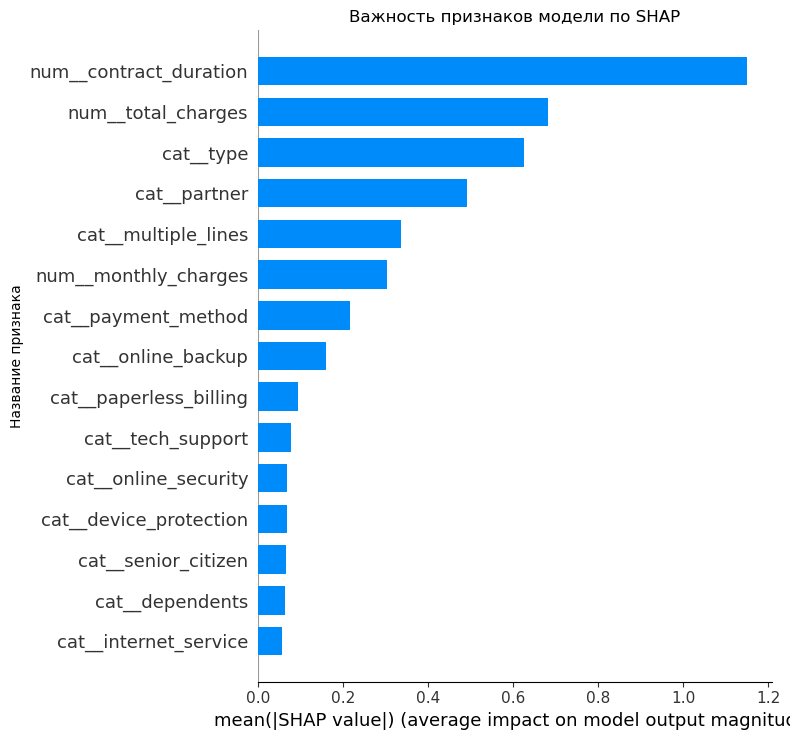

In [78]:
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out() 

data = pd.DataFrame(X_train_transformed, columns=feature_names)

# Создаем SHAP
explainer = shap.TreeExplainer(best_model.named_steps['models'])
shap_values = explainer.shap_values(data)

# График важности признаков
plt.ylabel("Название признака")
plt.title("Важность признаков модели по SHAP")
shap.summary_plot(shap_values, data, feature_names=feature_names, plot_type="bar", max_display=15)

plt.show()

Топ-5 наиболее важных признаков: 

- длительность контракта contract_duration,
- общие расходы total_charges,
- тип контракта по длительности type,
- семейное положение partner ,
- возможность подключения телефона к нескольким линиям multiple_lines

**Построим график влияния признаков на предсказание**

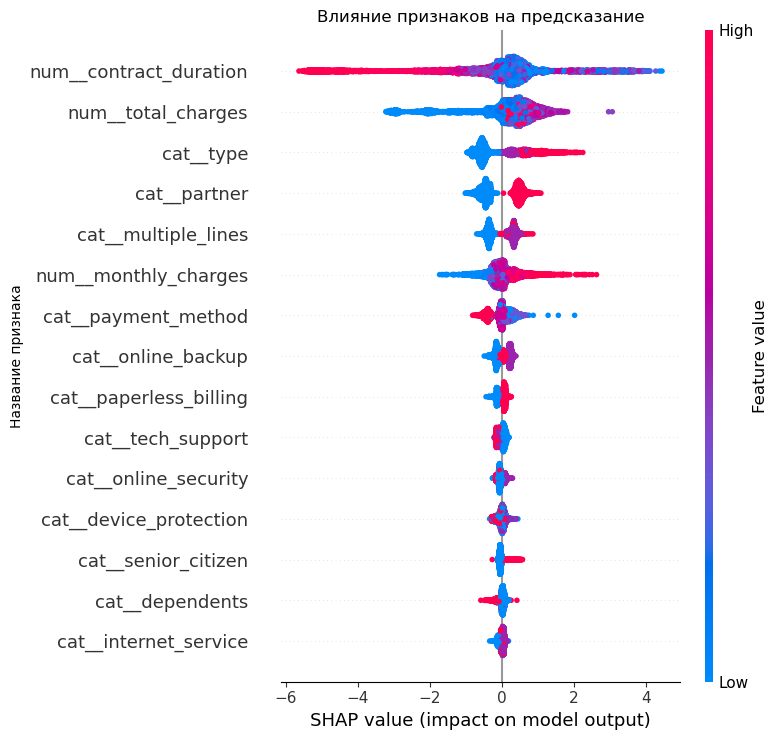

In [79]:
# График влияния признаков на предсказание
plt.ylabel("Название признака")
plt.title("Влияние признаков на предсказание")
shap.summary_plot(shap_values, data, feature_names=feature_names, max_display=15)

plt.show()

Признак длительность контракта 'contract_duration' действительно оказывает значительное влияние на предсказание модели. Более высокая длительность контракта увеличивает вероятность принадлежности к классу 0, а более низкая длительность увеличивает вероятность принадлежности к классу 1. Это видно по распределению SHAP значений: высокие значения длительности контракта связаны с SHAP значениями класса 0, а низкие значения — класса 1.

Признак 'total_charges' также имеет значительное влияние, особенно на класс 0. Более высокие общие расходы увеличивают вероятность принадлежности к классу 0. Это может быть связано с тем, что клиенты с большими общими расходами чаще остаются в классе 0.

Признак тип контракта по длительности 'type' оказывает более сильное влияние на класс 1. Это может быть связано с тем, что определенные типы контрактов (например, краткосрочные) чаще ассоциируются с классом 1.

Наличие партнера 'partner' оказывает примерно равное влияние на оба класса, для замужних\женатых людей есть невысокая вероятность принадлежности к классу 1, и наоборот. Возможно, наличие партнера указывает на то, что человек более склонен к уходу в процессе поиска более выгодных тарифов.

Наличие нескольких телефонных линий 'multiple_lines' аналогично оказывает умеренное влияние на оба класса. Возможно, это связано с тем, что люди, не пользующиеся несколькими телефонными линиями более консервативны и потому менее склонны разрывать контракт.

**Вывод: Было выполнено обучение моделей. Лучшей моделью стала CatBoostClassifier с гиперпараметрами models__max_depth = 5, models__learning_rate = 0.1, models__iterations = 500 .Метрика лучшей модели при кросс-валидации составила 0.91. Была проанализирована важность признаков по SHAP.** 

**Были выделены топ-5 наиболее важных признаков:**

- **длительность контракта 'contract_duration' (низкая длительность контракта увеличивает вероятность класса 1, высокая длительность - класса 0)**
- **общие расходы 'total_charges' (высокие расходы увеличивают вероятность класса 0)**
- **тип контракта по длительности 'type'(краткосрочные контракты чаще ассоциируются с классом 1)**
- **семейное положение 'partner'(семейные люди более склонны к классу 1)**
- **возможность подключения телефона к нескольким линиям 'multiple_lines'(люди с несколькими линиями склонны к классу 1)**

**Портрет пользователя, который уходит: это человек с краткосрочным контрактом, с типом оплаты 'ежемесячно', с низкими расходами, и семейным положением женат\замужем.**

## Выбор лучшей модели.

**Тестовая выборка**

Лучшей моделью оказалась модель CatBoost с параметрами 'models__max_depth'= 5, 'models__learning_rate'= 0.1, 'models__iterations'= 500. Ее и выберем для тестовой выборки. Проверим на тестовой выборке качество предсказаний выбранной модели.

In [80]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1] 

# Расчет метрик
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy on test set:", accuracy)
print("F1 score on test set:", f1)
print("ROC AUC score on test set:", roc_auc)


Accuracy on test set: 0.9220705346985211
F1 score on test set: 0.9158074369619937
ROC AUC score on test set: 0.9059563758389262


**Условие ROC AUC > 0.85 выполнено: ROC AUC равно 0.91. Модель хорошо различает положительные и отрицательные классы. Высокая точность accuracy (0.92) и F1 score (0.92) показывают, что модель не только правильно классифицирует большинство примеров, но и делает это с хорошей сбалансированностью между точностью и полнотой.**

**Матрица ошибок**

Построим матрицу ошибок, чтобы посмотреть как распределяются ошибки между классами.

Accuracy: 0.9220705346985211


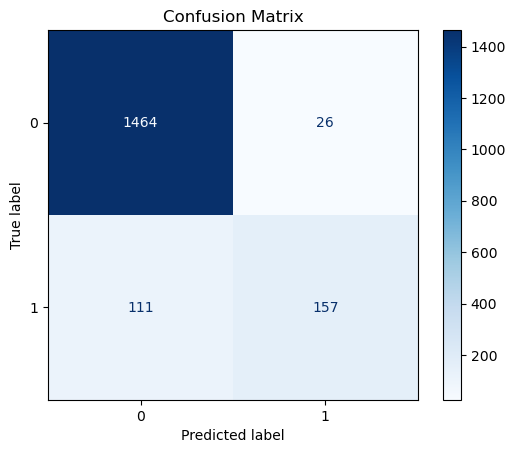

In [81]:
y_pred_binary = (y_pred_proba >= 0.5).astype(int)

# Оценка точности
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)

# Построение и визуализация матрицы ошибок
cm = confusion_matrix(y_test, y_pred_binary)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Модель для 1464 пользователей верно предсказала, что он продолжит покупать услуги компании, для 157 пользователей верно предсказала, что пользователь уйдет. Модель неверно предсказала для 111 пользователей, что они останутся, и для 26 неверно предсказала, что пользователи уйдут, тогда как они остались. Взависимости от задачи бизнеса, можно использовать разный порог классификации (любой менее 0.5, например, 0.3) и охватить большее количество абонентов, которые могут уйти.

**ROC кривая**

Построим ROC кривую.

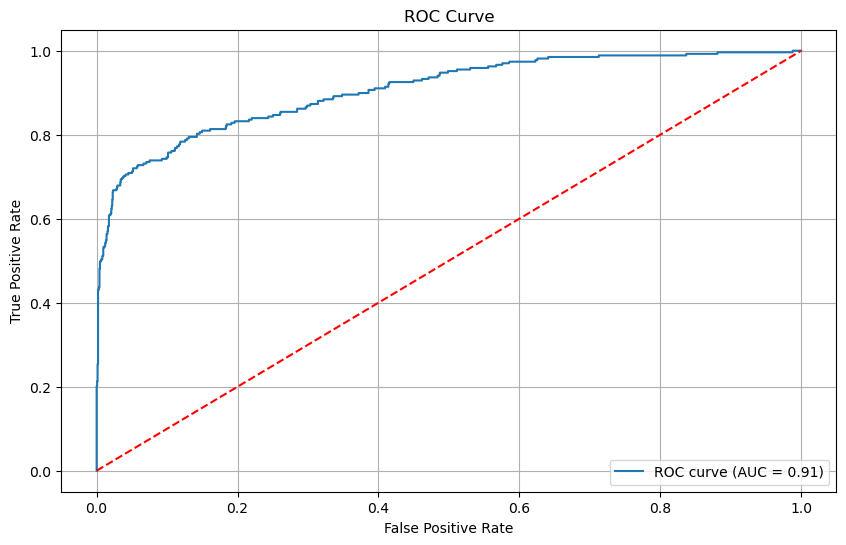

In [82]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Построение ROC-кривой
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'r--')  # Линия случайного угадывания
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

По оси True Positive Rate наблюдается очень хорошая чувствительность модели (доля истинно положительных случаев), по оси False Positive Rate можно отметить хорошую специфичность. Площадь под ROC кривой говорит о том, что модель хорошо различает классы. Сравнение с DummyModel (y=x красная пунктирная линия) говорит о том, что случайное угадывание работает несопоставимо хуже выбранной обученной модели.

**Вывод: Модель хорошо различает положительные и отрицательные классы roc_auc=0.91. Высокая точность accuracy (0.92) и F1 score (0.92) показывают, что модель не только правильно классифицирует большинство примеров, но и делает это с хорошей сбалансированностью между точностью и полнотой.**

**Модель для 1464 пользователей верно предсказала, что он продолжит покупать услуги компании, для 157 пользователей верно предсказала, что пользователь уйдет. Модель неверно предсказала для 111 пользователей, что они останутся, и для 26 неверно предсказала, что пользователи уйдут, тогда как они остались. Взависимости от задачи бизнеса, можно использовать разный порог классификации и охватить большее количество абонентов, которые могут уйти.**

**На графике кривой ROC AUC по оси True Positive Rate наблюдается очень хорошая чувствительность модели (доля истинно положительных случаев), по оси False Positive Rate можно отметить хорошую специфичность. Площадь под ROC кривой говорит о том, что модель хорошо различает классы. Сравнение с DummyModel (y=x красная пунктирная линия) говорит о том, что случайное угадывание работает несопоставимо хуже выбранной обученной модели.**

## Выводы

В проекте «ТелеДом» оператор связи стремится снизить отток клиентов, для этого было необходимо разработать модель для прогнозирования вероятности разрыва договора абонентами. Для задачи были предоставлены следующие данные: contract_new.csv — информация о договоре, personal_new.csv — персональные данные клиента, internet_new.csv — информация об интернет-услугах, phone_new.csv — информация об услугах телефонии.


Была выполнена предобработка данных, объединение информации из нескольких файлов, чтобы создать единый датафрейм для обучения моделей. Далее был проведен исследовательский анализ объединенного датафрейма, корреляционный анализ признаков, в результате признак 'gender' оказался незначимым и был удален, была также устранена мультиколлинеарность признаков.

В результате анализа было установлено, что 
- большинство пользователей используют ежемесячный платеж, 21.6% пользователей не пользуются интернет услугами
- есть многочисленная группа пользователей, у которых низкий тарифный план, либо промо-предложение, а группа пользователей с высокими тратами немногочисленна
- интернет услуги являются ключевым драйвером ежемесячных трат пользователей.
- есть значительная корреляция между общими расходами и длительностью контракта и расходами. Возможно, компании стоит мотивировать пользователей заключать более длительные контракты.

Для обучения были выбраны четыре модели: LogisticRegression, DecisionTreeClassifier, CatBoostClassifier,LGBMClassifier.

В результате обучения модель CatBoostClassifier с гиперпараметрами оказалась наиболее эффективной с метрикой roc_auc = 0.912, она и была выбрана для тестовой выборки. На тестовой выборке были получены следующие метрики: roc_auc = 0.91, accuracy = 0.92 и F1_score = 0.92. Модель отлично классифицирует большинство примеров с хорошей сбалансированностью между точностью и полнотой.

Взависимости от задачи бизнеса, можно использовать разный порог классификации (любой менее 0.5, например, 0.3), который позволит уменьшить ошибку второго рода (ложноотрицательные предсказания об уходе пользователя), и охватить большее количество абонентов, которые могут уйти.

Портрет пользователя, который уходит: это человек с краткосрочным контрактом, с типом оплаты 'ежемесячно', с низкими расходами, и семейным положением женат\замужем.

**Рекомендации заказчику:**

1. Стимулирование длительных контрактов: ввести бонусы или скидки для клиентов, которые готовы подписать долгосрочные контракты. Это может быть сниженная цена на тариф, бесплатные дополнительные услуги и т.д.

2. Использование предсказанний модели: специальные предложения для пользователей, для которых модель предсказывает высокую вероятность разрыва договора (использовать порог классификации для выявления наибольшего количества пользователей, готовых уйти, для наибольшего охвата таких пользователей)

3. Персонализированные предложения: использовать данные о пользователях для создания персонализированных предложений, например, специальные тарифы для пользователей, которые долгое время остаются на низком тарифе, для семейных пользователей.

4. Разработка пакетных предложений: создать привлекательные пакетные тарифы в том числе для тех пользоваталей, которые не используют интернет-услуги. Это может повысить интерес к интернет-услугам среди лояльных консервативных пользователей с низкими тарифами.

5. Поощрение и удержание пользователей с высокими расходами.

6. Обратная связь от пользователей: сбор и анализ отзывов от клиентов о тарифах и услугах, чтобы лучше понимать их потребности и адаптировать предложения под их ожидания.
